# Test on synthetic data generate from the CRUST1.0 model

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import time
from IPython.display import Image
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
from tesseroid_mesh import TesseroidRelief
from crust1 import fetch_crust1
from moho import MohoGravityInversion

## Create the model

In [2]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz')

In [3]:
reference = -30e3
mean_crust_density = crust1.density[5:8].mean(0)
moho_density_contrast = mean_crust_density - 3200
moho_density_contrast[-crust1.moho_depth > reference] *= -1

In [4]:
bm = Basemap(projection='moll', lon_0=0)
x, y = bm(crust1.lon, crust1.lat)

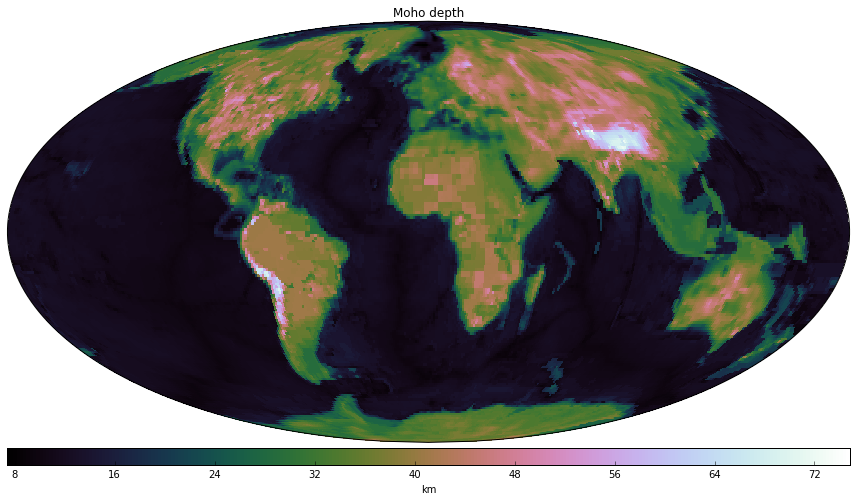

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Moho depth')
bm.pcolor(x, y, 0.001*crust1.moho_depth, cmap='cubehelix')
plt.colorbar(pad=0.01, aspect=50, orientation='horizontal').set_label('km')
plt.tight_layout()

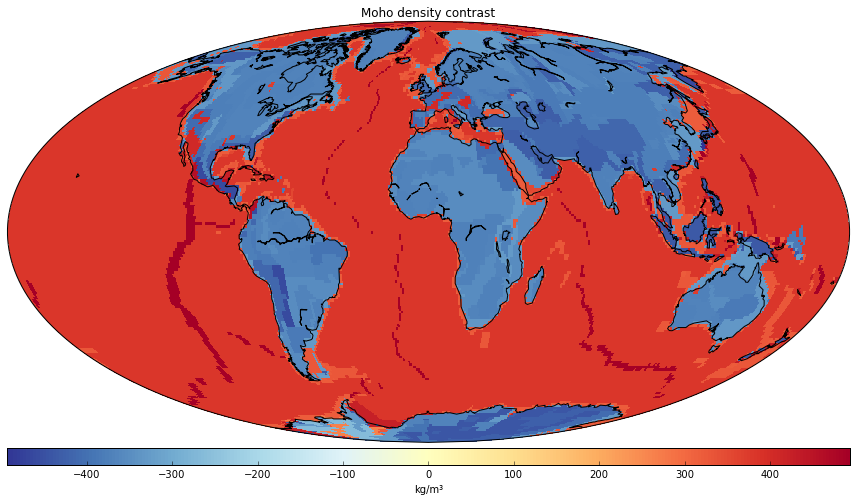

In [6]:
plt.figure(figsize=(12, 8))
plt.title('Moho density contrast')
bm.pcolor(x, y, moho_density_contrast, cmap='RdYlBu_r')
plt.colorbar(pad=0.01, aspect=50, orientation='horizontal').set_label(u'kg/m³')
bm.drawcoastlines()
plt.tight_layout()

In [5]:
area = (-180, 180, -90, 90)
shape = (180, 360)
model = TesseroidRelief(area, shape, relief=-crust1.moho_depth.ravel(), reference=reference, 
                        props={'density': moho_density_contrast.ravel()})

In [6]:
def plot_result_3d(moho, fname):
    scale = (1, 1, 20) # Exaggerate the radial dimension
    scene = myv.figure(zdown=False, size=(800, 600))
    plot = myv.tesseroids(moho, 'density', edges=False, scale=scale, cmap='RdYlBu')
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.data_range = [-500, 500]
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13996245,  0.8])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.moving = 0
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.8587985 ,  0.09092559])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    scene.scene.camera.position = [13318525.607091643, -13846570.310710395, -80414.851658120169]
    scene.scene.camera.focal_point = [603443.79675096623, 457522.8921213937, -95166.897647564474]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.026569467331130903, 0.024648560398787, 0.99934304013987463]
    scene.scene.camera.clipping_range = [1664660.8862110041, 41305079.657944612]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    myv.show()
    #myv.mlab.close()
    return Image(filename=fname)    

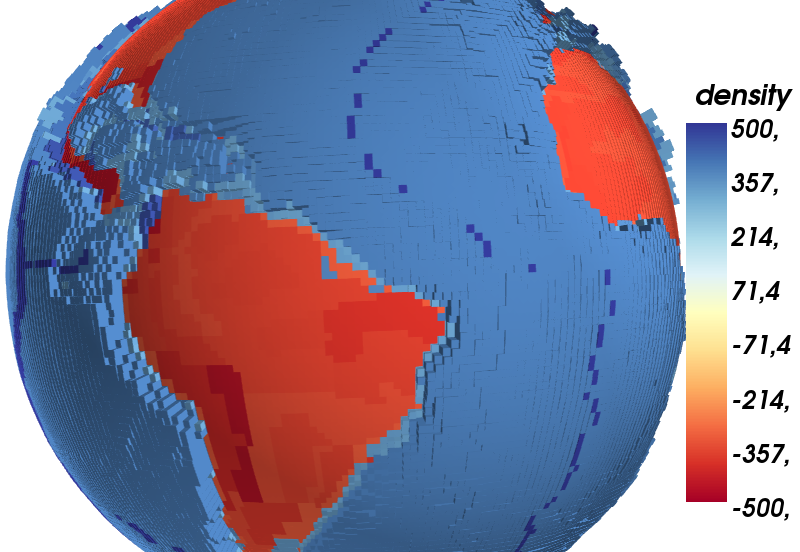

In [17]:
plot_result_3d(model, 'synthetic-crust1-model.png')

In [6]:
ncpu = multiprocessing.cpu_count()
ncpu

4

In [7]:
lon, lat = crust1.lon.ravel(), crust1.lat.ravel()
height = 250e3*np.ones_like(lon)

In [ ]:
t0 = time.time()
data = tesseroid.gz(lon, lat, height, model, njobs=ncpu)
print('Computation time: {} s'.format(time.time() - t0))

In [ ]:
with open('../data/crust1-moho-anomaly.txt', 'w') as f:
    f.write('# Synthetic data for a Moho gravity anomaly from the CRUST1.0 model\n')
    f.write('# Generated by synthetic-crust1.0-data.ipynb\n')
    f.write('# Columns:\n')
    f.write('# lon  lat  height[m]  gravity_anomaly[mGal]  moho_depth[m]  moho_density_contrast[kg/m^3]\n')
    np.savetxt(f, np.transpose([lon, lat, height, data, -moho_depth.ravel(), moho_density_contrast.ravel()]))